In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [ ]:
# prepare dataset and convert GDP and industrial production data into percentage changes
df = pd.read_csv('/content/gdrive/MyDrive/database/Q3_macro_data.csv', parse_dates=[0], index_col=0, date_format='%Y/%m/%d')
df = df.asfreq(pd.infer_freq(df.index))
df['GDP'] = df['GDP'].pct_change() * 100
df['INDPRO'] = df['INDPRO'].pct_change() * 100
df = df.dropna()

In [ ]:
df.head()

,GDP,INDPRO,UNRATE
DATE,,,
1948-04-01,2.568281,-0.750679,3.9
1948-07-01,2.432063,3.024727,3.6
1948-10-01,0.419060,-0.366736,3.7
1949-01-01,-1.901800,-3.130773,4.3
1949-04-01,-1.339107,-3.421949,5.3


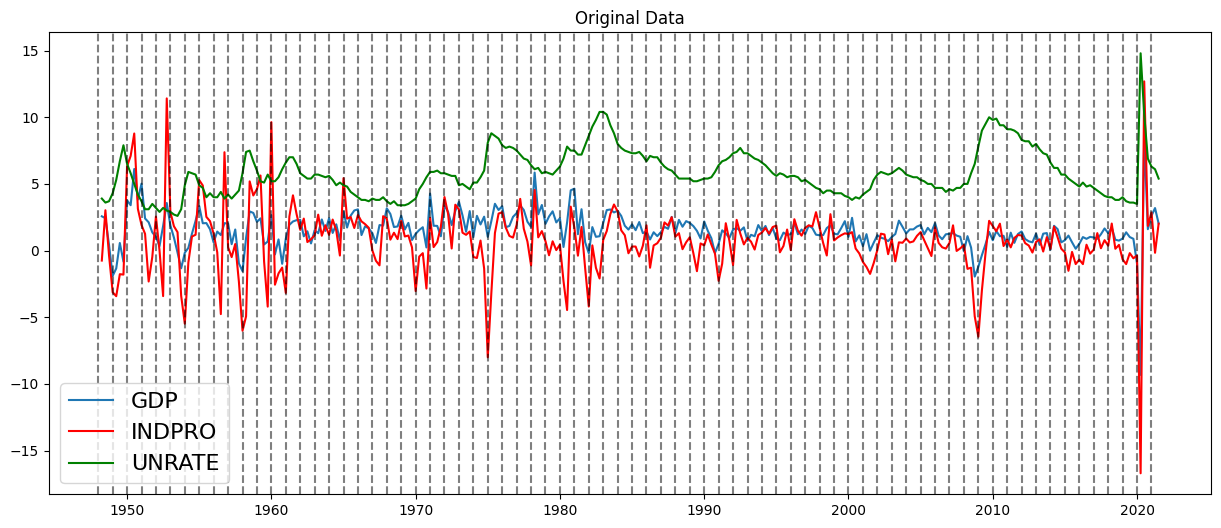

In [ ]:
# plot
plt.figure(figsize=(15,6))
gdp, = plt.plot(df['GDP'])
indpro, = plt.plot(df['INDPRO'], color='red')
unrate, = plt.plot(df['UNRATE'], color='green')
for year in range(1948, 2022):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.legend(['GDP', 'INDPRO', 'UNRATE'], fontsize=16)
plt.title('Original Data')
plt.show()

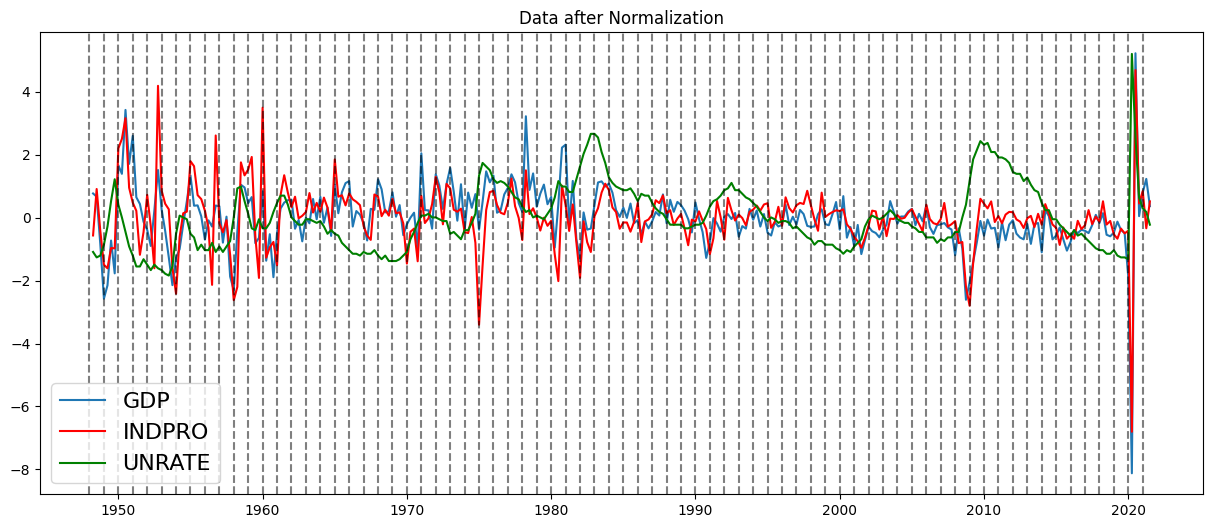

In [ ]:
# Normalize
avgs = df.mean()
devs = df.std()
for col in df.columns:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]
plt.figure(figsize=(15, 6))
gdp, = plt.plot(df['GDP'])
indpro, = plt.plot(df['INDPRO'], color='red')
unrate, = plt.plot(df['UNRATE'], color='green')

for year in range(1948, 2022):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
plt.legend(['GDP', 'INDPRO', 'UNRATE'], fontsize=16)
plt.title('Data after Normalization')
plt.show()

First, in order to better fit the VAR model, we performed standardization on each column, making the time series data more stationary. The following figure illustrates the time series after processing.

In [ ]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['GDP'])
print('ADF statistic for GDP: %f' % adf_result[0])
print('p-value for GDP: %f' % adf_result[1])

adf_result = adfuller(df['INDPRO'])
print('ADF statistic for industrial production: %f' % adf_result[0])
print('p-value for industrial production: %f' % adf_result[1])

adf_result = adfuller(df['UNRATE'])
print('ADF statistic for unemployment rate: %f' % adf_result[0])
print('p-value for unemployment rate: %f' % adf_result[1])

ADF statistic for GDP: -3.803135
p-value for GDP: 0.002875
ADF statistic for industrial production: -5.454292
p-value for industrial production: 0.000003
ADF statistic for unemployment rate: -4.396774
p-value for unemployment rate: 0.000301


Using the Augmented Dickey-Fuller (ADF) test to examine the stationarity of the time series, the p-values for all three time series (GDP, industrial production, and unemployment rate) are less than 0.05, indicating that they are all stationary. This provides a basis for the subsequent establishment of the VAR model, as the VAR model requires the input time series data to be stationary.

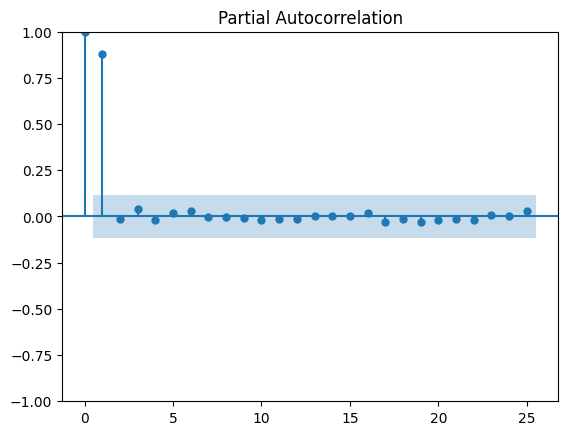

In [ ]:
# PACF for UNRATE - find the AR order for UNRATE
plot_pacf(df['UNRATE'])
plt.show()

The above figure shows the Partial Autocorrelation Function (PACF) plot for UNRATE, shows that the first three terms are significant and outside the confidence intervals denoted by the shaded blue region.

In [ ]:
all_results = []
for lag in range(1, 20):
    UNRATE_series = df['UNRATE'].iloc[lag:]
    INDPRO_series = df['INDPRO'].iloc[:-lag]

    result = pearsonr(UNRATE_series, INDPRO_series)
    result = [round(x, 4) for x in result]

    all_results.append({'lag': lag,
                        'pearson correlation': result[0],
                        'p-value': result[1]})

all_results = pd.DataFrame(all_results)
all_results

,lag,pearson correlation,p-value
0,1,-0.2216,0.0001
1,2,-0.2520,0.0000
2,3,-0.2586,0.0000
3,4,-0.2531,0.0000
4,5,-0.2052,0.0004
5,6,-0.2010,0.0006
6,7,-0.1919,0.0011
7,8,-0.1595,0.0069
8,9,-0.1509,0.0107
9,10,-0.1547,0.0090


In [ ]:
all_results = []
for lag in range(1, 20):
    GDP_series = df['GDP'].iloc[:-lag]
    UNRATE_series = df['UNRATE'].iloc[lag:]

    result = pearsonr(GDP_series, UNRATE_series)
    result = [round(x, 4) for x in result]

    all_results.append({'lag': lag,
                        'pearson correlation': result[0],
                        'p-value': result[1]})

all_results = pd.DataFrame(all_results)
all_results

,lag,pearson correlation,p-value
0,1,-0.1659,0.0044
1,2,-0.1834,0.0017
2,3,-0.1803,0.0020
3,4,-0.1526,0.0093
4,5,-0.0966,0.1012
5,6,-0.0789,0.1817
6,7,-0.0534,0.3674
7,8,-0.0091,0.8786
8,9,0.0143,0.8099
9,10,0.0273,0.6467


In [ ]:
df = df[['GDP', 'INDPRO', 'UNRATE']]
model = VAR(df)
model_fit_1 = model.fit(maxlags=11)
print(model_fit_1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Apr, 2025
Time:                     07:52:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.30008
Nobs:                     283.000    HQIC:                  -3.08715
Log likelihood:          -591.300    FPE:                  0.0270387
AIC:                     -3.61399    Det(Omega_mle):       0.0192383
--------------------------------------------------------------------
Results for equation GDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.024918         0.047056           -0.530           0.596
L1.GDP             0.531057         0.095478            5.562           0.000
L1.INDPRO         -0.038699         0.088244           -0.439           0.

The VAR package will fit a model for GDP, INDPRO, UNRATE, resulting in three sets of results: “Results for equation GDP”, “Results for equation INDPRO” and “Results for equation UNRATE”.

For regressing, the model used 16 lags of GDP, INDPRO, UNRATE. We will use only the lags with a low p-value, of less than 0.05, for our model.

we focus on the third set: For unemployment data we see that lags 1 has a low p-value. This confirms our interpretation of the PACF plot above. Similarly, the lag of 1 for GDP have a low p-value, and the lag of 1,2,3,4 for INDPRO have a low p-value.

Thus, we are left with 4 main terms: lags 1 for the UNRATE and lag 1 for GDP and lag 2,4 for the INDPRO. We take the corresponding coefficients to arrive at the following VAR model, where $\hat{U}$ denotes the forecasted value for unemployment data.

$$ \hat{U}_t = 0.186*U_{t-1} - 0.272*G_{t-1} + 0.186 * I_{t-2}- 0.13 * I_{t-4} $$






In [ ]:
summary_str =model_fit_1.summary()
fig, ax = plt.subplots(figsize=(10, 8))
ax.text(0.05, 0.95, summary_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.axis('off')
plt.tight_layout()
plt.savefig('model_summary.png', dpi=300, bbox_inches='tight')
plt.close(fig)

<ipython-input-44-af2fbb3ebf3a>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


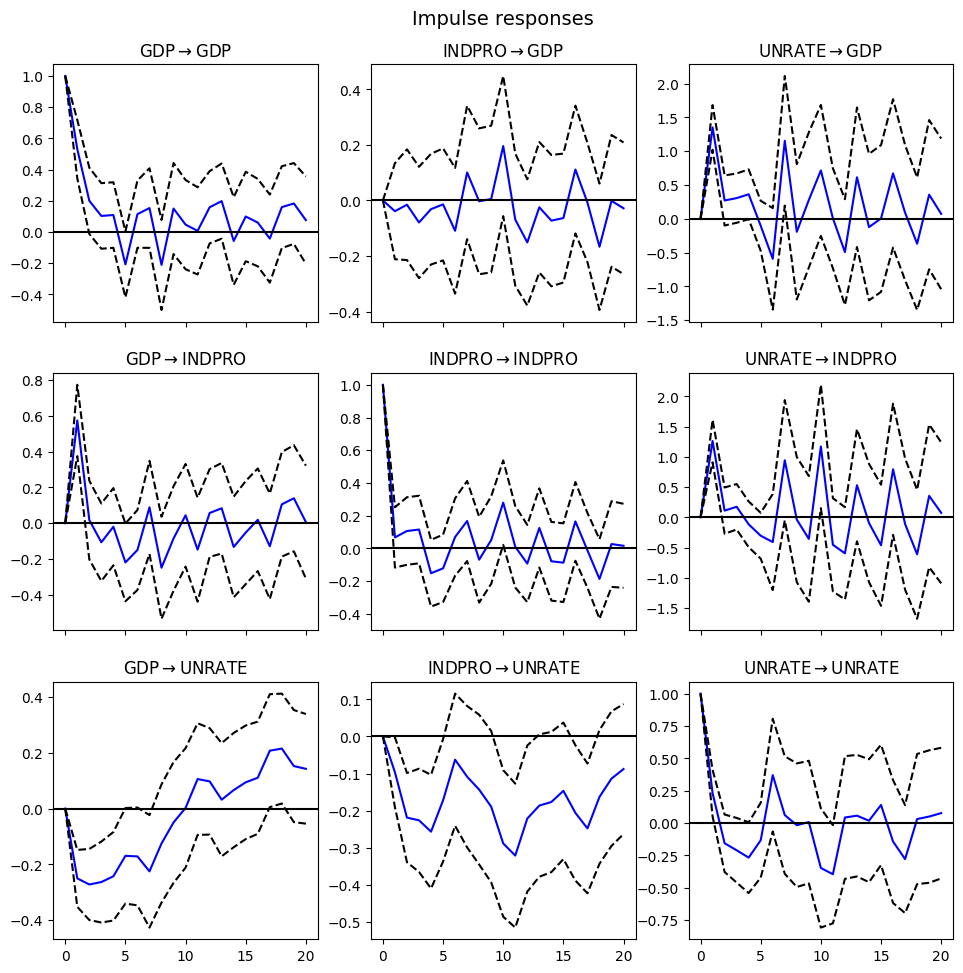

In [ ]:
# IRF, Cholesky
res_irf = model_fit_1.irf(20)
# plot IRF
res_irf.plot()
plt.show()

The graph presented illustrates the Impulse Response Functions (IRFs) of a Vector Autoregression (VAR) model, and below is a specific analysis of the changes affecting the unemployment rate (UNRATE).

GDP → UNRATE:

Initially, GDP has a negative impact on the unemployment rate. This effect transitions to a positive influence by the tenth period and appears to have a long-term impact.

INDPRO → UNRATE:

Industrial production has a long-term negative effect on the unemployment rate.

UNRATE → UNRATE:

The unemployment rate fluctuates due to its own shocks.